# Ejecución del Modelo

### A tener en cuenta

Cada modelo espera **características** diferentes para realizar la predicción. Por lo tanto, los datos deben corresponder y estar en el orden que se muestra a continuación:

- **Modelo global base**
 - LATITUDE_meters
 - LONGITUDE_meters
 - Velocity
 - Angle_V
 - dist_Tbar
- **Modelo global base + acceleration**
 - LATITUDE_meters
 - LONGITUDE_meters
 - Velocity
 - Angle_V
 - Acceleration
 - Angle_A
 - dist_Tbar
- **Modelo global base + wind**
 - LATITUDE_meters
 - LONGITUDE_meters
 - Velocity
 - Angle_V
 - Velocity_p
- **Modelo global base por aerolinea**
 - LATITUDE_meters
 - LONGITUDE_meters
 - Velocity
 - Angle_V
 - dist_Tbar


In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from sklearn.metrics import mean_absolute_error


import warnings
warnings.filterwarnings('ignore')

In [133]:
%run functions_exec.py

## Cargar el modelo entrenado

In [134]:
name_model = 'model_1_Global_base.pkl'
path_model = 'model/'

In [135]:
RFM = joblib.load(path_model + name_model)

----------------

# 1. Predicción para los puntos de un vuelo

Para realizar predicciones con un vuelo del que se conocen todos sun puntos hasta el momento de ingreso a la Tbar (se conoce el target) se debe:

1. Preprocesar los datos del vuelo.
2. Seleccionar las características correspondientes al modelos que se desea implementar para la predicción.
3. Obtener las predicciones con la función **predict()** del modelo implementado.

Una vez obtenidos los resultados de las predicciones se obtiene el error promedio absoluto al comparar los resultados de la predicción con el target con el que se cuenta en el dataset preprocesado.

## Preprocesar los datos del vuelo

In [136]:
# Archivo que contiene los datos de la Tbar.
# Este debe ser cargado para determinar si el vuelo
# tiene puntos que pasen por la Tbar, determinar a que Tbar se 
# dirige si existe más de una Tbar, entre otros parámetros 
# necesarios. Estos son explicados en el Notebook 01.
path_tbar = 'datasets/points.csv'

# Ruta en donde se encuentra el archivo con los datos de un vuelo
path_dataset = 'test/flight_id_301.csv'

# Estos datos se encuentran descritos en el notebook 01. Son usados para 
# filtrar los puntos de la trayectoría de un vuelo
radio_filter = 600000
T = 5

# Llamado de la función de preprocesado
data_flight = transform_dataset(path_tbar, path_dataset, radio_filter, T)

In [137]:
# Las condiciones de preprocesado son:
# - El vuelo tenga puntos de su trayectoría dentro del área circular demarcada
#   por el radio desde el punto rwy de la Tbar
#   (ó punto medio de los puntos rwy, si existe más de una Tbar)
# - El vuelo pase sobre la Tbar

if data_flight.empty:
    print('El vuelo no tiene cumple las condiciones de preprocesado')

## Leer las características necesarios para el modelo cargado

In [138]:
X = data_flight[['LATITUDE_meters', 'LONGITUDE_meters', 
          'Velocity', 'Angle_V',
          'dist_Tbar']]

y = data_flight['Target_sec']

## Realizar las predicciones del vuelo cargado

In [139]:
y_pred = RFM.predict(X)

## Error promedio de la predicción

In [140]:
print('Mean absolute error Test: %.2f' % mean_absolute_error(y, y_pred) + ' seconds')

Mean absolute error Test: 10.95 seconds


In [141]:
error = Error_point(y_pred, y)
error = error.reset_index(drop=True)

-----------
## Métricas

-----------

In [142]:
data_predict = pd.DataFrame()
df_dist_Tbar = X['dist_Tbar']
df_dist_Tbar = df_dist_Tbar.reset_index(drop=True)

data_predict = pd.concat([data_predict, df_dist_Tbar], axis=1)
data_predict = data_predict.reset_index(drop=True)


data_predict = pd.concat([data_predict, error], axis=1)
data_predict = data_predict.rename(columns={'dist_Tbar' : 'Dist', 
                                         'Target_sec' : 'Error'})
data_predict = data_predict.reset_index(drop=True)

In [143]:
delta_dist = 2000
max_dist = 100000
data_range = data_range_(delta_dist, max_dist, data_predict)
data_range = data_range.reset_index(drop=True)

(0, 100)

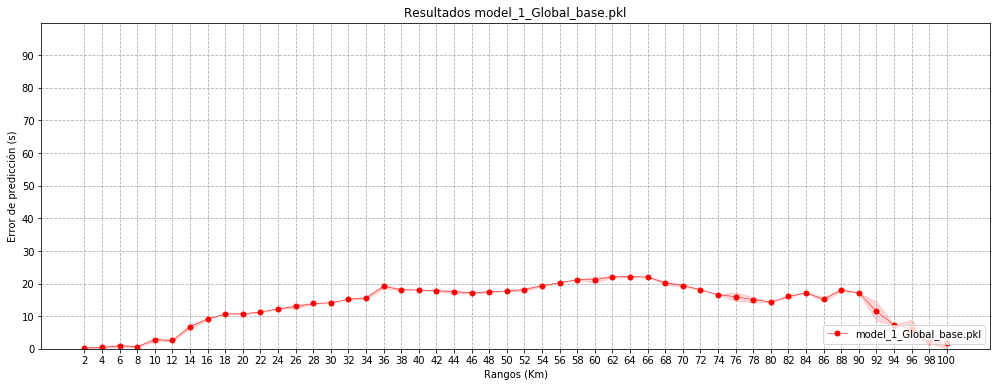

In [144]:
plt.figure(figsize=(17,6))
plt.subplot(111)

# train score
plt.plot(data_range['Range'].values, 
         data_range['mean_RF'].values, 
         color='r', 
         linewidth=0.5, 
         marker='o', 
         markersize=5, 
         label=name_model)
plt.fill_between(data_range['Range'].values, 
                 data_range['mean_RF'].values + data_range['std_RF'].values, 
                 data_range['mean_RF'].values - data_range['std_RF'].values,
                 alpha=0.15, 
                 color='r')


plt.grid(linestyle='--')
plt.title('Resultados ' + name_model)
plt.legend(loc='lower right')
plt.xlabel('Rangos (Km)')
plt.ylabel('Error de predicción (s)');
plt.xticks(data_range['Range'])
plt.yticks(range(0,100,10))
plt.ylim(0, 100)


--------------------

--------------------

# 2. Para un punto

Para realizar la predicción de un punto dado del vuelo en donde no se conoce el target se debe:

1. Preprocesar el punto del vuelo.
3. Seleccionar las características correspondientes al modelos que se desea implementar para la predicción.
4. Obtener las predicciones con la función **predict()** del modelo implementado.

Una vez obtenidos los resultados de las predicciones se obtiene el error promedio absoluto al comparar los resultados de la predicción con el target con el que se cuenta en el dataset preprocesado.

## Preprocesar un punto de un vuelo

In [166]:
# Archivo que contiene los datos de la Tbar.
# Este debe ser cargado para determinar la distancia 
# desde el punto hasta la intercepción con la Tbar
path_tbar = 'datasets/points.csv'

# Ruta en donde se encuentra el archivo con los datos de un vuelo
path_point = 'test/point_flight_577.csv'


# Especificar a que Tbar se dirige el vuelo y a que punto de la misma
# Esto es necesario para calcular la distancia a la Tbar y realizar la predicción
name_tbar = 'tbar2'
point_tbar = 'center'


# Llamado de la función de preprocesado
data_point = transform_point(name_tbar, point_tbar, path_tbar, path_point)

In [167]:
data_point

,ID,CALLSIGN,AC_REAL_MODEL,Tbar,LATITUDE_meters,LONGITUDE_meters,Velocity,Angle_V,Acceleration,Angle_A,dist_Tbar,Velocity_p
0,577,WZZ2490,unknown,tbar2,6.120440e+06,2.345641e+06,204.99761,-1.561706,0.064306,0.0,218030.938167,-0.027588


## Leer las características necesarios para el modelo cargado

In [168]:
X = data_point[['LATITUDE_meters', 'LONGITUDE_meters', 
          'Velocity', 'Angle_V',
          'dist_Tbar']]

## Realizar la predicción sobre el punto que se ha cargado 

In [169]:
y_pred = RFM.predict(X)

In [170]:
print('Tiempo hasta la ' + name_tbar + ': ' + str(y_pred[0]) +  ' seconds')

Tiempo hasta la tbar2: 882.911271186 seconds
